# 0. Overview

We will be analyzing an extract of 1994 U.S. Census data. See more on the data set [here](https://archive.ics.uci.edu/ml/datasets/census+income). First, we are going to need some help from some well-known, third-party libraries:

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

Third-party libraries are libraries (collections of code) that do not come with the core Python distribution. You can get these libraries through downloading the Anaconda distribution, which includes them all, or through installing them manually with `pip` (or `pip3`, depending on your system), which is the Python package manager.

When importing a Python library, you can give it an alias, which is usually done to make something easier to type. It's good to follow standard protocol for a given library when doing this so that other people will recognize it throughout your code. 

`numpy` (typically abbreviated as `np`) provides the following:
- a homogenous (read: for a single data type) array with very useful manipulation methods
- a number of useful advanced math functions
- other data type helpers
- in many ways `numpy` is a collection of Python wrappers for very well-optimized C and FORTRAN math code

`pandas` (typically abbreviated as `pd`) is:
- a library that provides, amongst other things, a very nice data structure known as the `DataFrame`
- the `DataFrame` is a relational / tabular data structure
- i.e. it allows you to do SQL-ish analysis in Python
- it also visualizes nicely in Jupyter notebooks
- a good bit of Pandas is actually just user-friendly interfaces on top of `numpy`

`matplotlib` (from which the `pyplot` submodule is typically imported and aliased as `plt`)
- the old faithful data visualization library for Python
- it definitely provides a steep learning curve
- but it's a powerful tool once learned



In [2]:
%matplotlib inline

The above is a _magic_ Jupyter command that ensures all `matplotlib` plots will by default show in the notebook.

# 1. Get Data

### Retrieve and quick look

`pandas` provides us with a function that makes it very easy to read-in tabular data: `read_csv()`. In this case we pass the name of the file we want to read along with the value `None` for `header`, which tells the function that the file does not have a header / column name row.

In [3]:
data = pd.read_csv("census_data.csv", header=None)

When we read the data using this function, we are returned a `DataFrame` - this is a `pandas` data structure that is very useful for data analysis, in part because it provides a whole lot of very convenient methods (it will also visualize well in Jupyter notebooks). We can look at a `tuple` of (`number of rows`, `number of columns`):

In [4]:
data.shape

(32561, 15)

We can call `.iloc` on the `DataFrame` to select rows based on their _integer location_, kind of like we'd do with a `list`. In fact, the same slicing rules apply:

In [5]:
data.iloc[:5, :8]

,0,1,2,3,4,5,6,7
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife


We see that, as expected, the data came in with no columns. I know the column names, so we can create a `list` of column names (whose length must be equal to the width of the `DataFrame`) and set the `DataFrame`'s `columns` attribute equal to it:

In [6]:
cols = ['age', 'workclass', 'fnlwgt', 'education', 
        'education_num', 'marital_status', 'occupation',
        'relationship', 'race', 'sex', 'capital_gain',
        'capital_loss', 'hours_per_week', 'native_country', 
        'over_fifty_k']

In [7]:
data.columns = cols

In [8]:
data.iloc[:5, :8]

,age,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife


I generally like to start any analysis by looking at the top and bottom of the data that's been read in, to ensure columns are named appropriately, no junk data was picked up at the end, etc.

In [9]:
data.iloc[-5:, -7:]

,race,sex,capital_gain,capital_loss,hours_per_week,native_country,over_fifty_k
32556,White,Female,0,0,38,United-States,<=50K
32557,White,Male,0,0,40,United-States,>50K
32558,White,Female,0,0,40,United-States,<=50K
32559,White,Male,0,0,20,United-States,<=50K
32560,White,Female,15024,0,40,United-States,>50K


#### Problem

Look at rows 100 _through_ 110, in colums 10 and 11, and make sure all the data looks OK.

### Cleanliness check

It's important to always check to see if you have any duplicates or missing values in your data before you really get going. `pandas` makes both tasks very easy:

In [10]:
data.duplicated().sum()

24

In this case we have some duplicates in our data! Let's take a look at where they are in the index:

In [11]:
data[data.duplicated()].index

Int64Index([ 4881,  5104,  9171, 11631, 13084, 15059, 17040, 18555, 18698,
            21318, 21490, 21875, 22300, 22367, 22494, 25872, 26313, 28230,
            28522, 28846, 29157, 30845, 31993, 32404],
           dtype='int64')

One of the ways in which we can filter a `DataFrame` is to pass a condition into it using square brackets, e.g. `data[data.duplicated()]`. 

`duplicated()` is a method that returns `True` for every row in `data` that is a duplicate. The square bracket syntax works such that it will then return the rows in the `DataFrame` that have a value of `True`. So, `duplicated` returns a whole collection of `True` or `False` values for each position in the index, and the square bracket syntax then returns the the row for each `True` index value. 

In this case, we only want the index of these rows, not the whole row, so we call the `index` attribute on the results of the square bracket query. 

Let's quickly look at another example of filtering using the square bracket syntax:

In [12]:
len(data[data.capital_gain > 0])

2712

Above we've filtered the `DataFrame` to only the rows in which `capital_gain` is greater than 0. We then pass the results of that into the built-in `len` function, which will tell you how many items are in the iterable that's been passed.

#### Problem

Count the number of rows in the table corresponding to folks who are over the age of 30.

Now, let's go ahead and drop our duplicate values:

In [13]:
data = data.drop_duplicates()

In [14]:
data.duplicated().sum()

0

We can also check for `null` or missing values:

In [15]:
data.isnull().sum()

age               0
workclass         0
fnlwgt            0
education         0
education_num     0
marital_status    0
occupation        0
relationship      0
race              0
sex               0
capital_gain      0
capital_loss      0
hours_per_week    0
native_country    0
over_fifty_k      0
dtype: int64

# 2. Exploratory Data Analysis

Exploratory data analysis (EDA) is key to understanding your data - this is where you poke around and see how things work.

In [16]:
data.dtypes.value_counts()

object    9
int64     6
dtype: int64

`data.dtypes` tells us the data type for every column in `data`. The `value_counts()` method then returns the frequency of each type.

### `education`

Let's dive deeper into a single column of the `DataFrame`. `DataFrame` columns are instances of what `pandas` calls the `Series` class - they're kinda like `DataFrames`, and the two have many common attributes and methods, but `Series` objects contain, for the purposes of this discussion, only an index and a single column of data.

In [17]:
data.education.head()

0     Bachelors
1     Bachelors
2       HS-grad
3          11th
4     Bachelors
Name: education, dtype: object

#### Problem

Tell me the most frequent education level in the data. 

In [18]:
data.education.nunique()

16

`nunique()` is a `Series` method that tells us how many unique values there are. 

We can pass `normalize=True` to `value_counts()` to see, instead of the value count, the value proportion of the entire dataset:

In [19]:
data.education.value_counts(normalize=True)

 HS-grad         0.322525
 Some-college    0.223807
 Bachelors       0.164520
 Masters         0.052924
 Assoc-voc       0.042475
 11th            0.036113
 Assoc-acdm      0.032793
 10th            0.028675
 7th-8th         0.019824
 Prof-school     0.017703
 9th             0.015797
 12th            0.013308
 Doctorate       0.012693
 5th-6th         0.010204
 1st-4th         0.005102
 Preschool       0.001537
Name: education, dtype: float64

We can now go ahead and plot this data if we'd like:

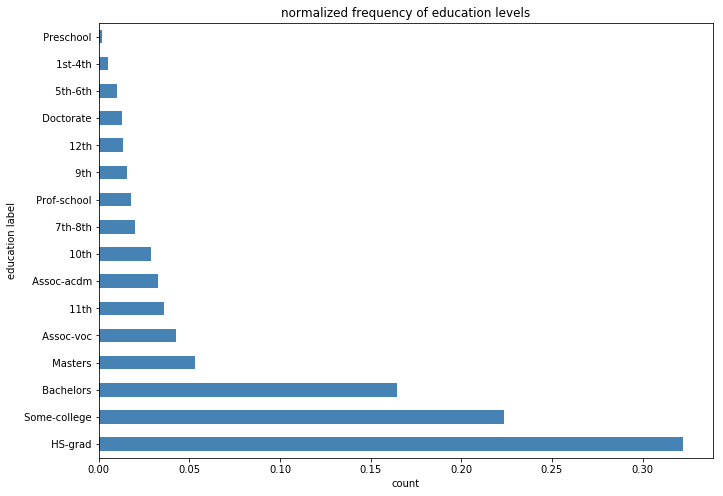

In [20]:
ax = data.education.value_counts(normalize=True).plot.barh(figsize=(11, 8), color="steelblue")
xlab = ax.set_xlabel("count")
ylab = ax.set_ylabel("education label")
t = ax.set_title("normalized frequency of education levels")

`DataFrame` and `Series` objects come with some nice plotting functionality built-in, a lot of which wraps the `matplotlib` library. 

One of the ways to get at the different types of plots is to first access `plot` (as we did) but not call it (i.e. no `()`) and instad call a particular type of plot method available through `plot` (in this case, `barh`).

We passed some arguments to `barh()` to change the size of the plot and the color of the bars. We've also set X and Y labels, as well as a title (always give your plots titles!). 

#### Problem

Pick another column in the data, one which doesn't have too many values, and produce the most common values in that column. Then, plot your resuls.

### `over_fifty_k`

In [21]:
data.over_fifty_k.value_counts(normalize=True)

 <=50K    0.759074
 >50K     0.240926
Name: over_fifty_k, dtype: float64

In [22]:
data.over_fifty_k.unique()

array([' <=50K', ' >50K'], dtype=object)

In this case, I don't love these `str` representations of what is really `bool` data (you can see that they have issues, in the form of leading spaces). Let's write a function to convert these values to `bool` type, and then `apply` that function over the rows of the `DataFrame`. The `apply` method allows you to write your own functionality when the `DataFrame` doesn't have what you want built-in:

In [23]:
def is_over_fifty_k(income):
    return income.strip() == ">50K"

In [24]:
data["over_fifty_k_bool"] = data.over_fifty_k.apply(is_over_fifty_k)

The above shows how you create a new column in `pandas`: `df["new_column_name"] = ...`

In [25]:
data.over_fifty_k_bool.head()

0    False
1    False
2    False
3    False
4    False
Name: over_fifty_k_bool, dtype: bool

We can use a SQL-style _join_ to connect our new column directly to the original column, meaning pandas will line up the data in the two columns based on where there indices overlap.

In [26]:
data.over_fifty_k.to_frame().join(data.over_fifty_k_bool).head()

,over_fifty_k,over_fifty_k_bool
0,<=50K,False
1,<=50K,False
2,<=50K,False
3,<=50K,False
4,<=50K,False


You'll notice above that we call `to_frame()` on `data.over_fifty_k`.

The pandas `Series` and `DataFrame` share a lot of functionality. But, every once in a while, you'll want to run a function on a `Series`, only to find that it's only available in the `DataFrame`, and that's what's happened here - you can only call `join()` from a `DataFrame`.

Plus, the DataFrame output looks much nicer in Jupyter. So `to_frame()` allows you to quickly convert a `Series` to a `DataFrame`.

In [27]:
data.over_fifty_k_bool.value_counts(normalize=True)

False    0.759074
True     0.240926
Name: over_fifty_k_bool, dtype: float64

#### Problem

Perform a similar data cleaning on `martial_status`, where you'll create a new column, `marital_status_clean`, for which leading a trailing spaces have been removed. You should also lowercase these values. While you're at it, you might as well go ahead and plot the normalized value counts for this `marital_status_clean` column. Try changing the plot color and title around to your liking.

### `capital_gain`

In [28]:
data.capital_gain.describe()

count    32537.000000
mean      1078.443741
std       7387.957424
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max      99999.000000
Name: capital_gain, dtype: float64

A great way to get acquainted with a `Series` is to call the `describe()` method, which will return a `Series` of the following descriptive statistics (for continuous data - the results are a little different for categorical / label data):
- number of non-null items
- arithmetic average and stardard deviation
- the following quantiles: [0, .25, .5, .75, 1]

Note that you can also produce all these statistics individually, e.g.

In [29]:
data.capital_gain.mean()

1078.4437409718166

In [30]:
data.capital_gain.quantile([0, .25, .5, .75, 1])

0.00        0.0
0.25        0.0
0.50        0.0
0.75        0.0
1.00    99999.0
Name: capital_gain, dtype: float64

Let's graph `data.capital_gain` as a histogram, which buckets the data into evenly-spaced bins and returns the number of items in each bin. This will give us a good feel for the data's distribution:

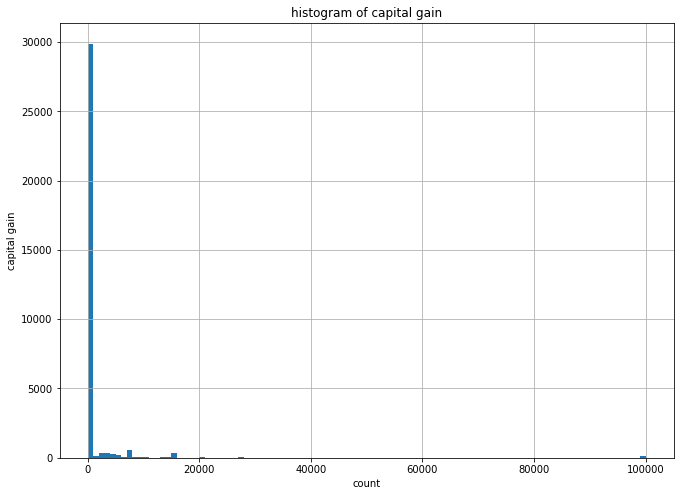

In [31]:
ax = data.capital_gain.hist(figsize=(11, 8), bins=100)
xlab = ax.set_xlabel("count")
ylab = ax.set_ylabel("capital gain")
t = ax.set_title("histogram of capital gain")

We can see that so much of `data.capital_gain` has a value of 0 that it's hard to really look at the non-zero data. Let's filter to only values greater than 0 and try again.

To achieve this, we can use `loc` to query the `DataFrame`, by following the form of: `DataFrame.loc[row_selection, column_selection]`

In [32]:
capital_gains_filtered = data.loc[data.capital_gain > 0, "capital_gain"]

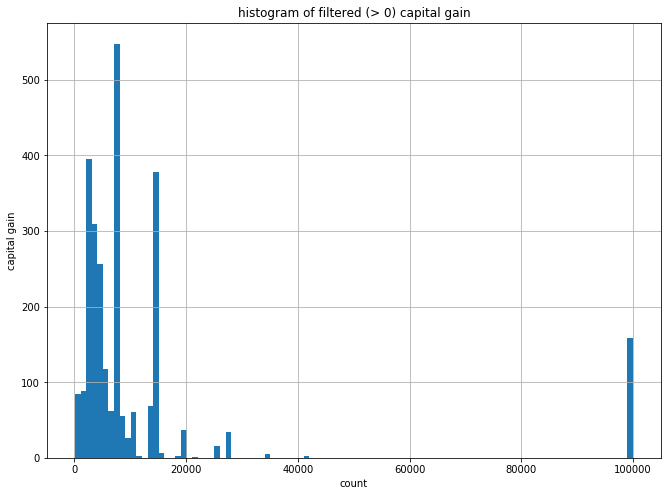

In [33]:
ax = capital_gains_filtered.hist(figsize=(11, 8), bins=100)
xlab = ax.set_xlabel("count")
ylab = ax.set_ylabel("capital gain")
t = ax.set_title("histogram of filtered (> 0) capital gain")

This is an interesting distribution - we see a sort of positively skewed (long tail to the right) mess with a weird spike at $100,000, where this data was likely capped and bucketed.

#### Problem

Produce a similar analysis for `capital_loss`. 

### Back to `capital_gain`

Let's say that we came to find out that all of the 0's in `capital_gain` were in fact just representations of `null` data. 

Note that people really do this, and that it's terrible - this is numerical data, which means that 0 has a meaning. The only time this really makes sense is if 0 is actually an extreme / impossible value for the data. Even then, that would be considered a pre-modeling treatment and not something you'd want to distribute to other folks as part of your core data set.

But let's say that, hypothetically, this happened - what would you do? You might start by re-representing the `null` data in its correct form.

In [34]:
cap_gain_missing = data.capital_gain

In [35]:
cap_gain_missing = cap_gain_missing.apply(lambda x: np.nan if x == 0 else x)

Here we've run `apply` with a function that returns `np.nan` (a `pandas`-friendly `null` encoding from `numpy`), but instead of using the usual `def` syntax to define the function, we've used `lambda`.

Our `lambda` function is what's referred to as an _anonymous function_, as it's never formally defined and given a name. This can be a great way to write on-the-go or throw-away functions (as we've done here).

In [36]:
cap_gain_missing.isnull().sum()

29825

We can also quickly fill our missing values using the `fillna()` method, if we've determined that replacing with 0 is the right thing to do:

In [37]:
cap_gain_missing = cap_gain_missing.fillna(0)

In [38]:
cap_gain_missing.isnull().sum()

0

### Looking at multiple columns: `education` and `capital_gain`:

Let's say you'd want to look at how one data set lies when it's grouped around another - how would you do that? You would call the `groupby()` method, which operates similarly to the `group by` syntax in SQL, and which provides some of the functionality that's encapulated in `pivot` in Excel.

`groupby()` works as follows:
1. select the data you'd like to query
2. call `groupby()` and pass to it the column(s) you'd like to group around
3. call some sort of aggregation function

In this case we want to:
1. query `education` and `capital_gain`, so we call `data[["education", "capital_gain"]]` (multiple columns require double brackets)
2. pass `education` to `groupby`
3. call `mean()`, which will give us the average capital gain for each group

In [39]:
data[["education", "capital_gain"]
    ].groupby(["education"]
    ).mean()

,capital_gain
education,
10th,404.574491
11th,215.097872
12th,284.087760
1st-4th,127.391566
5th-6th,176.551205
7th-8th,234.302326
9th,342.089494
Assoc-acdm,640.399250
Assoc-voc,715.051375


#### Problem

Perform a similar aggregation of `capital_loss`, and then _join_ those results to the results for `capital_gain`.

We can now plot these results:

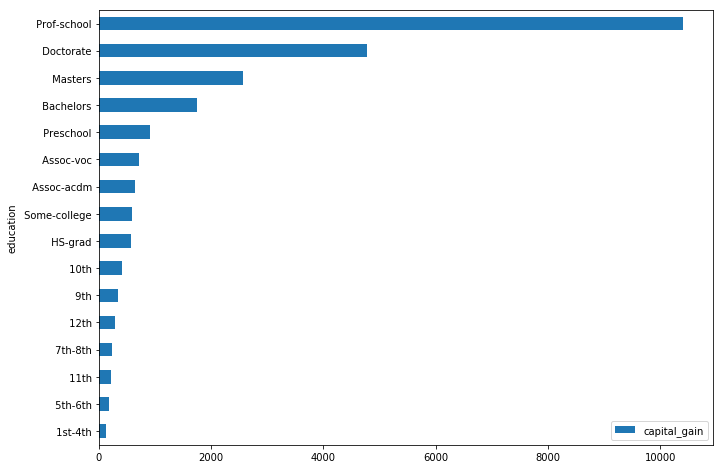

In [40]:
ax = data[["education", "capital_gain"]
          ].groupby(["education"]
          ).mean(
          ).sort_values("capital_gain"
          ).plot.barh(figsize=(11, 8))

Can we break this analysis out by whether or not someone's making over $50K?

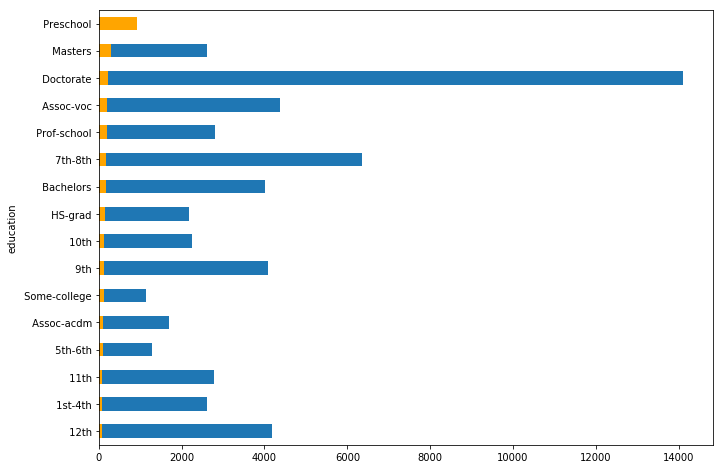

In [52]:
ax = data.loc[data.over_fifty_k_bool, ["education", "capital_gain"]
             ].groupby(["education"]
             ).mean(
             ).plot.barh(figsize=(11, 8))

ax = data.loc[~data.over_fifty_k_bool, ["education", "capital_gain"]
             ].groupby(["education"]
             ).mean(
             ).sort_values("capital_gain"
             ).plot.barh(figsize=(11, 8), color="orange", ax=ax)

ax.get_legend().remove()

#### Problem

Similarly to what you did before, get average capital loss for each education group, and join that into the results for capital gain.

This time, howver, you should make a `ratio` column, which represents the ratio of loss to gain, in the resulting table. 

Finally, plot the `ratio` column similar to what we've done directly above, where we've broken out the data by `over_fifty_k_bool`. Feel free to have some fun with the colors and whatnot!